In [1]:
# Versão do Python
from platform import python_version
print("Versão da Linguagem Python Usada neste Notebook: ", python_version())

Versão da Linguagem Python Usada neste Notebook:  3.9.12


In [2]:
# Instalação dos pacotes em suas versões
#!pip install -q -U matplotlib==3.4.3
#!pip install -q -U watermark

In [3]:
# https://pypi.org/project/findspark/
#!pip install -q findspark

In [4]:
# Importando o findspark e inicializar
import findspark
findspark.init()

In [5]:
# Imports
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator


In [6]:
# Formatação da Saída
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 400)
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel("ERROR")

In [7]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Eric Gomes" --iversions

Author: Eric Gomes

numpy     : 1.22.4
findspark : 2.0.1
seaborn   : 0.11.2
sys       : 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
matplotlib: 3.4.3
pyspark   : 3.3.0
pandas    : 1.4.3



### Preparando o Ambiente Spark

In [8]:
# Definindo semente aleatória (seed) para reprodutibilidade do Notebook
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

In [9]:
# Criando o Spark Context
sc = SparkContext(appName = 'predict_crypto_price')

In [10]:
# Criando a sessão Spark
spark_session = SparkSession.Builder().getOrCreate()

In [11]:
# Visualizar o objeto saprk_session
spark_session

### Carregando os Dados 

In [12]:
# Carrega os dados a partir da sessão Spark
df_spark = spark_session.read.csv("data/dataset.csv", header = "true", inferSchema = "true")

In [13]:
# Tipos de Objeto
type(df_spark)

pyspark.sql.dataframe.DataFrame

In [14]:
# Visualiza os dados
df_spark.show()

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319660| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345100| NaN| NaN| NaN|  NaN|       

In [15]:
# Verifica o número de linhas
df_spark.count()

4856600

### Data Wrangling com SparkSQL

In [16]:
# Criar uma tabela temporária a partir do dataframe
# As tabelas temporárias são úteis quando você deseja que o conjunto de resultados fique visível 
# para todas as outras sessões Spark
df_spark.createOrReplaceTempView("dados_bitcoin")

In [17]:
# Executa uma consulta SQL
df_bitcoin = spark_session.sql("select *, from_unixtime(Timestamp) as `datetime` from dados_bitcoin")

In [18]:
type(df_bitcoin)

pyspark.sql.dataframe.DataFrame

In [19]:
#Visualiza os dados
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           datetime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 05:52:00|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:15:00|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:16:00|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:17:00|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:18:00|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:19:00|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:20:00|


In [20]:
# Número de registros
df_bitcoin.count()

4856600

In [21]:
# Removendo valores NA (Não faz sentido qualquer tratamento aqui, pois todas as colunas de cotações 
#estão como NA)
df_bitcoin = df_bitcoin.dropna("any")

In [22]:
# Visualizar os dados
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           datetime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 05:52:00|
|1325346600|4.39|4.39|4.39| 4.39|        48.0|           210.72|          4.39|2011-12-31 13:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57| 37.86229723|     171.38033753|  4.5264114983|2011-12-31 14:59:00|
|1325350800|4.58|4.58|4.58| 4.58|         9.0|            41.22|          4.58|2011-12-31 15:00:00|
|1325391360|4.58|4.58|4.58| 4.58|       1.502|          6.87916|          4.58|2012-01-01 02:16:00|
|1325431680|4.84|4.84|4.84| 4.84|        10.0|             48.4|          4.84|2012-01-01 13:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|        10.1|             50.5|           5.0|2012-01-01 20:45:00|


In [23]:
df_bitcoin.count()

3613769

In [24]:
# Vamos renomear algumas colunas para facilitar a manipulação do dados.
df_bitcoin = df_bitcoin.withColumnRenamed("Volume_(BTC)", "VolBTC").withColumnRenamed(
    "Volume_(Currency)", "VolCurrency")

In [25]:
# Visualiza
df_bitcoin.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           datetime|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 05:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 13:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 14:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 15:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 02:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 13:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|       10.1|        50.5|           5.0|2012-01-01 20:45:00|
|1325534640| 5.0| 5.0| 5.0|  5.0|     19.048|       95.24|  

A coluna dateTime fornece os detalhes da data de cotação. Vamos serapra os elementos da data em diferentes colunas

In [26]:
# Vamos dividir o dataframe extraindo data
df_data = df_bitcoin.withColumn("date", split(col("dateTime"), " ").getItem(0))

In [27]:
type(df_data)

pyspark.sql.dataframe.DataFrame

In [28]:
# Dividir o dataframe extraindo time
df_data = df_data.withColumn("time", split(col("dateTime"), " ").getItem(1))

In [29]:
# Schema
df_data.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- datetime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)



In [30]:
df_data.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           datetime|      date|    time|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 05:52:00|2011-12-31|05:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 13:50:00|2011-12-31|13:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 14:59:00|2011-12-31|14:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 15:00:00|2011-12-31|15:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 02:16:00|2012-01-01|02:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 13:2

In [31]:
# Vamos dividir o dataframe exrtraindo a hora
df_data_hora = df_data.withColumn("hour", split(col("time"), ":").getItem(0))

In [32]:
df_data_hora.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- datetime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: string (nullable = true)



In [33]:
df_data_hora.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           datetime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 05:52:00|2011-12-31|05:52:00|  05|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 13:50:00|2011-12-31|13:50:00|  13|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 14:59:00|2011-12-31|14:59:00|  14|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 15:00:00|2011-12-31|15:00:00|  15|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 02:16:00|2012-01-01|02:16:00|  02|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|   

In [34]:
# Vamos ajustar o formato da data para extrair o dia da semana
df_data_hora = df_data_hora.withColumn("date", df_data_hora["date"].cast(DateType())).withColumn("hour", df_data_hora["hour"].cast(DoubleType())).withColumn("dateTime", df_data_hora["datetime"].cast(DateType()))

In [35]:
df_data_hora.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|05:52:00| 5.0|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|13:50:00|13.0|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|14:59:00|14.0|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|15:00:00|15.0|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|02:16:00| 2.0|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01|2012-01-01|13:28:00|13.0|
|132545790

In [36]:
# Vamos extrair o dia da semana
df_data_hora = df_data_hora.withColumn("day_of_week", dayofweek(df_data_hora.date))

In [37]:
df_data_hora.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: date (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [38]:
# Vamos extrair o ano da cotação
df_data_hora_ano = df_data_hora.withColumn("year", split(col("date"), "-").getItem(0))

In [39]:
df_data_hora_ano.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|day_of_week|year|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|05:52:00| 5.0|          7|2011|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|13:50:00|13.0|          7|2011|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|14:59:00|14.0|          7|2011|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|15:00:00|15.0|          7|2011|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|02:16:00| 2.0|  

In [40]:
# Converter o dataframe do Spark para o Pandas
# Por que? Porque isso vai facilitar a análise exploratória de dados.
df_pandas = df_data_hora_ano.toPandas()

In [41]:
type(df_pandas)

pandas.core.frame.DataFrame

### Análise Exploratória

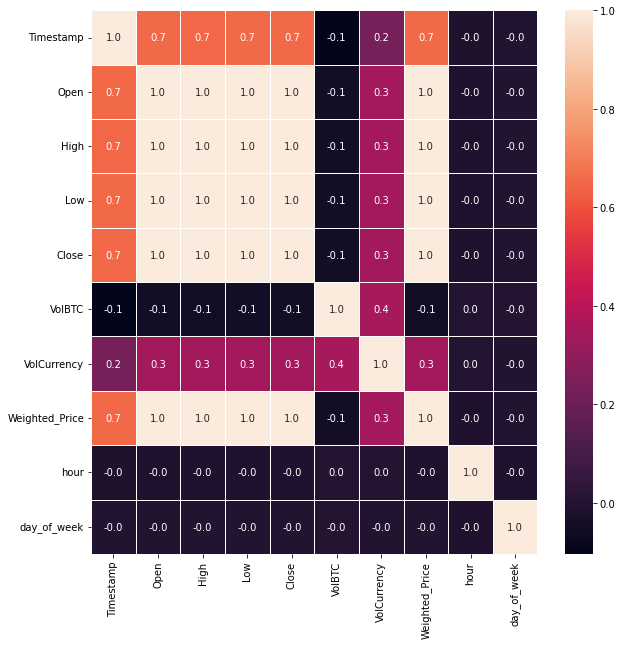

In [42]:
# Heatmap para visualizar a correlaçaõ
corr = df_pandas.corr()
f, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(corr, annot =  True, linewidths = 0.5, fmt = '.1f', ax = ax);

Idealmente queremos alta correlação entre as variáveis de entra e a variável de saída e baixa correlação entre as variáveis de entrada!

<Figure size 864x360 with 0 Axes>

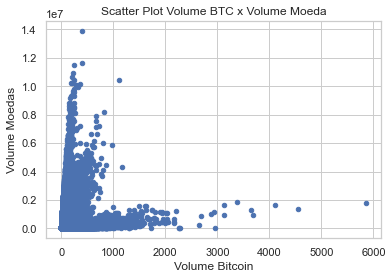

In [43]:
# Scatter Plot Volumen Bitcoin x Volume Moeda
plt.figure(figsize=(12, 5))
sns.set(style="whitegrid")
df_pandas.plot(kind="scatter", x = "VolBTC", y = "VolCurrency")
plt.xlabel("Volume Bitcoin")
plt.ylabel("Volume Moedas")
plt.title("Scatter Plot Volume BTC x Volume Moeda")
plt.show()

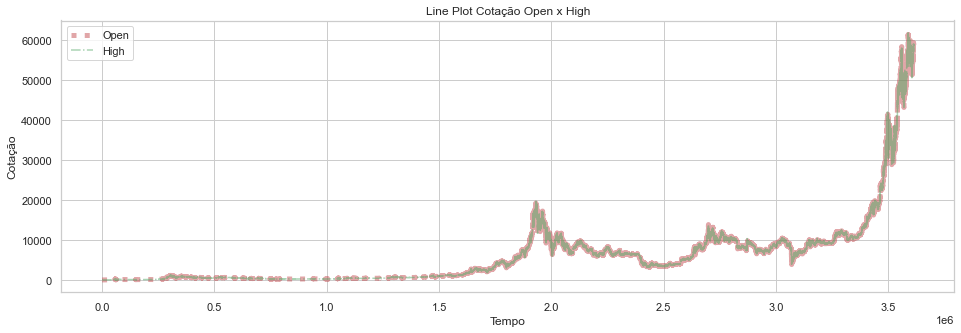

In [44]:
# Line Plot Cotação Open x High
plt.figure(figsize = (16, 5))
df_pandas.Open.plot(kind = "line", 
                    color = "r",
                    label = "Open",
                    alpha = 0.5, 
                    linewidth = 5,
                    grid = True, 
                    linestyle = ":")
df_pandas.High.plot(color = "g",
                    label = "High", 
                    alpha = 0.5, 
                    grid = True, 
                    linestyle = "-.")
plt.legend(loc = "upper left")
plt.xlabel("Tempo")
plt.ylabel("Cotação")
plt.title("Line Plot Cotação Open x High")
plt.show();

<AxesSubplot:ylabel='Frequency'>

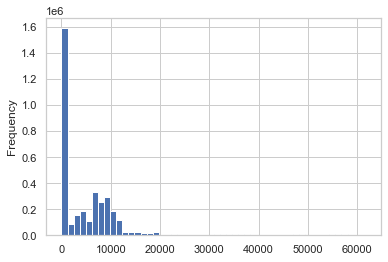

In [45]:
# Histograma da cotação de abertura
df_pandas.Open.plot(kind = "hist", bins = 50)

<function matplotlib.pyplot.show(close=None, block=None)>

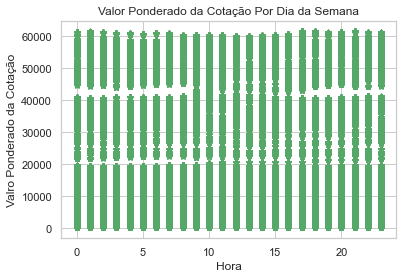

In [46]:
# Plot do valor ponderado da cotação (Variável alvo) por hora
plt.plot(df_pandas.hour, df_pandas.Weighted_Price , 'g*')
plt.xlabel('Hora')
plt.ylabel('Valro Ponderado da Cotação')
plt.title('Valor Ponderado da Cotação Por Dia da Semana')
plt.show

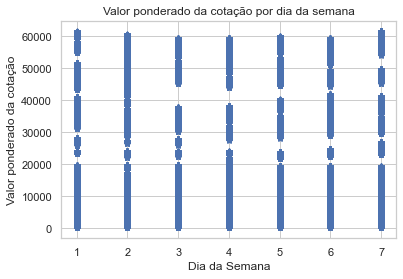

In [47]:
# Plot do valor ponderado da cotação por dia da semana
plt.plot(df_pandas.day_of_week, df_pandas.Weighted_Price, 'b*')
plt.xlabel("Dia da Semana")
plt.ylabel("Valor ponderado da cotação")
plt.title("Valor ponderado da cotação por dia da semana")
plt.show()

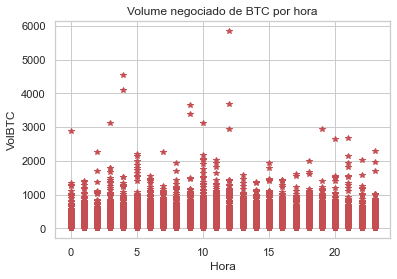

In [48]:
# Plot do VolBTC por hora
plt.plot(df_pandas.hour, df_pandas.VolBTC, 'r*')
plt.xlabel("Hora")
plt.ylabel("VolBTC")
plt.title("Volume negociado de BTC por hora")
plt.show()

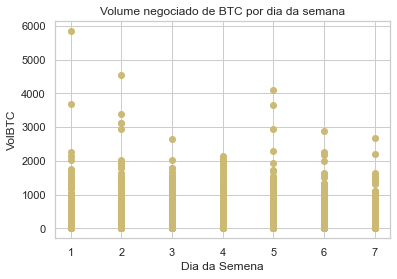

In [49]:
# Plot de VolBTC por dia da semana
plt.plot(df_pandas.day_of_week, df_pandas.VolBTC, 'yo')
plt.xlabel("Dia da Semena")
plt.ylabel("VolBTC")
plt.title("Volume negociado de BTC por dia da semana")
plt.show()

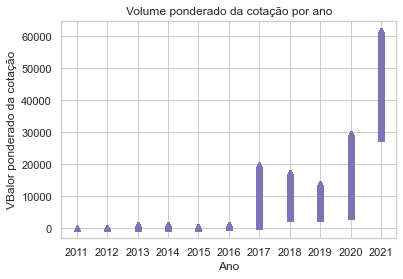

In [50]:
# Plot de valor ponderado da cotação por ano
plt.plot(df_pandas.year, df_pandas.Weighted_Price, 'm^')
plt.xlabel("Ano")
plt.ylabel("VBalor ponderado da cotação")
plt.title("Volume ponderado da cotação por ano")
plt.show()

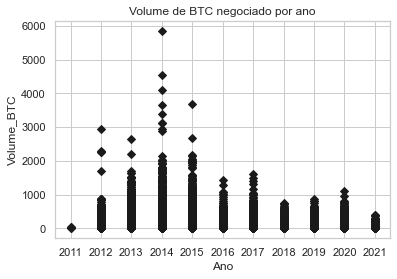

In [51]:
# Plot do Volume por Ano
plt.plot(df_pandas.year, df_pandas.VolBTC, 'kD')
plt.xlabel("Ano")
plt.ylabel("Volume_BTC")
plt.title("Volume de BTC negociado por ano")
plt.show()

In [52]:
### Engenharia de Atributos com PySpark
df_bitcoin.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- datetime: string (nullable = true)



In [53]:
# Prepara o vetor de atributos
assembler = VectorAssembler(inputCols = ["Open", "VolBTC", "VolCurrency"],
                            outputCol = "Features")

In [54]:
# Cria o dataframe do vetor de atributos
df_assembled = assembler.transform(df_bitcoin)

In [55]:
df_assembled.show(10, truncate = False)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|Timestamp |Open|High|Low |Close|VolBTC     |VolCurrency |Weighted_Price|datetime           |Features                      |
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|1325317920|4.39|4.39|4.39|4.39 |0.45558087 |2.0000000193|4.39          |2011-12-31 05:52:00|[4.39,0.45558087,2.0000000193]|
|1325346600|4.39|4.39|4.39|4.39 |48.0       |210.72      |4.39          |2011-12-31 13:50:00|[4.39,48.0,210.72]            |
|1325350740|4.5 |4.57|4.5 |4.57 |37.86229723|171.38033753|4.5264114983  |2011-12-31 14:59:00|[4.5,37.86229723,171.38033753]|
|1325350800|4.58|4.58|4.58|4.58 |9.0        |41.22       |4.58          |2011-12-31 15:00:00|[4.58,9.0,41.22]              |
|1325391360|4.58|4.58|4.58|4.58 |1.502      |6.87916     |4.58          |2012-01-01 02:16:00|[4.58,1.502,6.87916]          |


In [56]:
### Normalização
dados_treino, dados_teste = df_assembled.randomSplit([.7, .3], seed = rnd_seed)

In [57]:
type(dados_treino)

pyspark.sql.dataframe.DataFrame

In [58]:
# Cria o scaler
scaler = MinMaxScaler(inputCol = "Features", outputCol="scaled_features")

In [59]:
# Fit nos dados de treino
scalerModel = scaler.fit(dados_treino)

In [60]:
# Fit e transform nos dados de treino
dados_treino_scaled = scalerModel.transform(dados_treino)

In [61]:
# Transform nos dados de teste
dados_teste_scaled = scalerModel.transform(dados_teste)

In [62]:
dados_treino_scaled.select("Features", "scaled_features").show(10, truncate = False)

+-------------------------------+-------------------------------------------------------------------+
|Features                       |scaled_features                                                    |
+-------------------------------+-------------------------------------------------------------------+
|[4.39,48.0,210.72]             |[9.553145931914242E-6,0.008199728766573702,1.51589789206087E-5]    |
|[4.5,37.86229723,171.38033753] |[1.1334240936169445E-5,0.006467928495112392,1.2328924278777876E-5] |
|[4.58,9.0,41.22]               |[1.2629582757445955E-5,0.001537449143732569,2.9653241795154263E-6] |
|[4.84,10.0,48.4]               |[1.68394436765946E-5,0.001708276826369521,3.4818459555688167E-6]   |
|[5.0,10.1,50.5]                |[1.9430127319147618E-5,0.0017253595946332162,3.63291778421953E-6]  |
|[5.14,0.68,3.4952]             |[2.16969755063815E-5,1.1616282419312745E-4,2.5144107404760596E-7]  |
|[5.26,29.31939163,154.21999997]|[2.3639988238296265E-5,0.00500856372847815,1.1094

In [63]:
dados_treino_scaled.columns

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'VolBTC',
 'VolCurrency',
 'Weighted_Price',
 'datetime',
 'Features',
 'scaled_features']

### Machine Learning

    Versão 1 - (Banchmark)

In [64]:
# Criar o modelo de regressão
modelo_lr_v1 = (LinearRegression(featuresCol = "scaled_features", 
                                 labelCol = 'Weighted_Price',
                                 predictionCol = "Predicted_Price",
                                 maxIter = 100, 
                                 regParam = 0.3, 
                                 elasticNetParam = 0.8, 
                                 standardization = False))

In [65]:
# Treinar o modelo 
modelo_v1 = modelo_lr_v1.fit(dados_treino_scaled)

Se tiver mensagem de WARN, isso indica que o Spark não encontrou a biblioteca de otimização de álgebra linear (que precisa ser instalada, mas não é requerida para este projeto). Mais detalhes aqui:
                                                                                                              
https://spark.apache.org/docs/latest/ml-linalg-guide.html

In [66]:
# Salvar o modelo em disco - No windows recebo erro que não encontrei solução ainda.
#path = "modelos/modelo_v1"
#modelo_v1.write().overwrite().save("modelos/modelo_v1")

### Avaliação do modelo

In [67]:
# Previsões com dados de teste
previsoes_v1 = modelo_v1.transform(dados_teste_scaled)

In [68]:
#previsoes_v1.columns
pred_data_V1 = previsoes_v1.select("Predicted_Price", "Weighted_Price").show(10)

+------------------+--------------+
|   Predicted_Price|Weighted_Price|
+------------------+--------------+
| 7.461481293392899|          4.39|
|7.6513811117446355|          4.58|
| 8.071159657574789|           5.0|
|  8.39099093058824|          5.32|
| 8.361006748743229|          5.29|
| 8.361006748743229|          5.29|
| 8.261059475926526|          5.19|
|  8.43096983971492|  5.3604618117|
| 8.820764203700064|   5.777027027|
| 9.070632385741822|           6.0|
+------------------+--------------+
only showing top 10 rows



In [69]:
# Mean Absolute Error
print("Mean Absolute Error (MAE) nos dados de teste: {0}".format(modelo_v1.summary.meanAbsoluteError))

Mean Absolute Error (MAE) nos dados de teste: 5.0199998354459865


In [70]:
# Criar um avaliador para o modelo de regressão
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_Price", 
                                metricName = "rmse"
                               )

In [71]:
# Aplicar o avaliador
rmse_v1 = evaluator.evaluate(previsoes_v1)
print("Root Mean Squared Error (RMSE) nos dados de teste = %g" % rmse_v1)

Root Mean Squared Error (RMSE) nos dados de teste = 11.4206


In [72]:
# Extrair as previsões
pred_results_v1 = modelo_v1.evaluate(dados_teste_scaled)


In [73]:
# Valores reais de Y sendo convertidos para o formato do Pandas
Y = pred_results_v1.predictions.select("Weighted_Price").toPandas()

In [74]:
# Valores previstos de Y sendo convertidos para o formato do Pandas
_Y = pred_results_v1.predictions.select("Predicted_Price").toPandas()

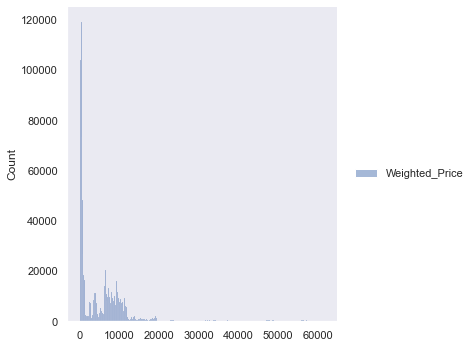

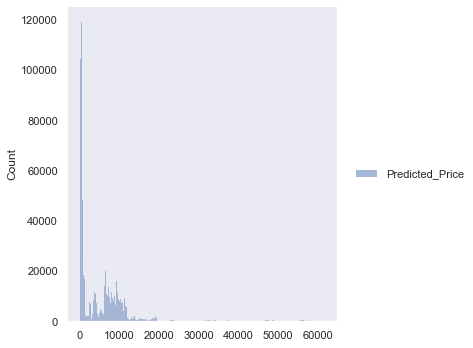

In [75]:
# Distribuição dos valores reais x valores previstos
sns.set_style("dark")
ax1 = sns.displot(Y, color = "r", label = "Valores Reais")
sns.displot(_Y, color = "b", label = "Valores Previstos")

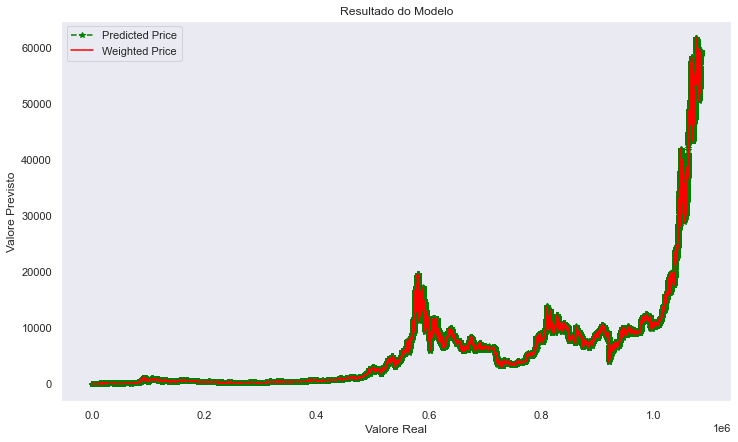

In [76]:
# Plot dos valores reais x valores previstos
plt.figure(figsize = (12, 7))
plt.plot(Y, color = "green", marker = "*", linestyle = "dashed", label = "Predicted Price")
plt.plot(_Y, color = "red", label = "Weighted Price")
plt.title("Resultado do Modelo")
plt.xlabel("Valore Real")
plt.ylabel("Valore Previsto")
plt.legend()

    Versão 2 do Modelo (Otimização de Hiperparâmetros)

In [77]:
# Criar o modelo 
modelo_lr_v2 = (LinearRegression(featuresCol = "scaled_features", 
                                 labelCol = "Weighted_Price", 
                                 predictionCol = "Predicted_Price"))

In [78]:
# Criar um grid para otimização de Hiperparâmetro
grid = ParamGridBuilder().addGrid(modelo_lr_v2.maxIter, [50, 100]).build()

In [79]:
# Criar o avaliador (Será usado na validação cruzada)
evaluator = RegressionEvaluator(labelCol = "Weighted_Price" , 
                                predictionCol = "Predicted_Price", 
                                metricName = "rmse")

In [80]:
# Criar o CrossValidator
cv = CrossValidator(estimator = modelo_lr_v2, 
                    estimatorParamMaps = grid, 
                    evaluator = evaluator, 
                    parallelism = 2)

In [81]:
# reina o CrossValidator
cvModel = cv.fit(dados_treino_scaled)

In [82]:
# Extrair o melhor modelo do 
modelo_v2 = cvModel.bestModel

Se tiver mensagem de WARN, isso indica que o Spark não encontrou a biblioteca de otimização de álgebra linear (que precisa ser instalada, mas não é requerida para este projeto). Mais detalhes aqui:

https://spark.apache.org/docs/latest/ml-linalg-guide.html

In [83]:
# Salvar o modelo em disco
#modelo_v2.write().overwrite().save("modelo/modelo_v2")

### Avaliando o modelo V2

In [84]:
# Previsões com dados de teste
previsoes_v2 = modelo_v2.transform(dados_teste_scaled)

In [85]:
# Selecionar as colunas
pred_data_v2 = previsoes_v2.select("Predicted_Price", "Weighted_Price").show(10)

+------------------+--------------+
|   Predicted_Price|Weighted_Price|
+------------------+--------------+
| 4.502119998497504|          4.39|
| 4.692288571880474|          4.58|
| 5.115092950536393|           5.0|
| 5.432426809952907|          5.32|
| 5.406694437802658|          5.29|
|5.4038345805494234|          5.29|
| 5.302464037330834|          5.19|
| 5.474202029454054|  5.3604618117|
| 5.864358012805859|   5.777027027|
|6.1123889361125645|           6.0|
+------------------+--------------+
only showing top 10 rows



In [86]:
# MEAN ABSOLUTE ERROR
print("MAE: {0}".format(modelo_v2.summary.meanAbsoluteError))

MAE: 3.383969736258383


In [87]:
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_Price", 
                                metricName = "rmse")

In [88]:
# Aplicar o avaliador
rmse_v2 = evaluator.evaluate(previsoes_v2)
print("Root Mean Sqared Error (RMSE) nos dados de teste = %g" % rmse_v2)

Root Mean Sqared Error (RMSE) nos dados de teste = 10.4871


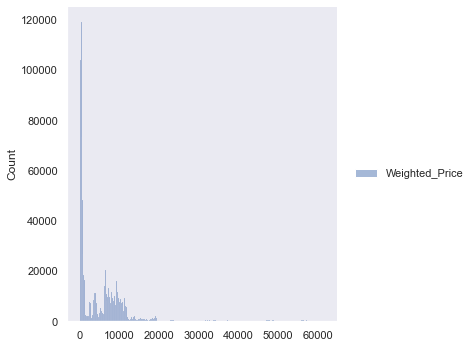

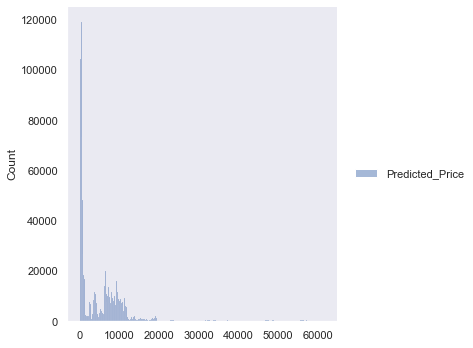

In [89]:
# Plot dos valores reais x Valores previstos
# Extrair as previsões
pred_result_v2 = modelo_v2.evaluate(dados_teste_scaled)

# Valores Reais de Y sendo convertidos para o formato do Pandas
Y = pred_result_v2.predictions.select("Weighted_Price").toPandas()

# Valores previstos de Y sendo convertidos para o formato do Pandas
_Y = pred_result_v2.predictions.select("Predicted_Price").toPandas()

# Plot
sns.set_style("dark")
ax1 = sns.displot(Y, color = "r", label = "Valores Reais")
sns.displot(_Y, color = "g", label = "Valores Previstos");

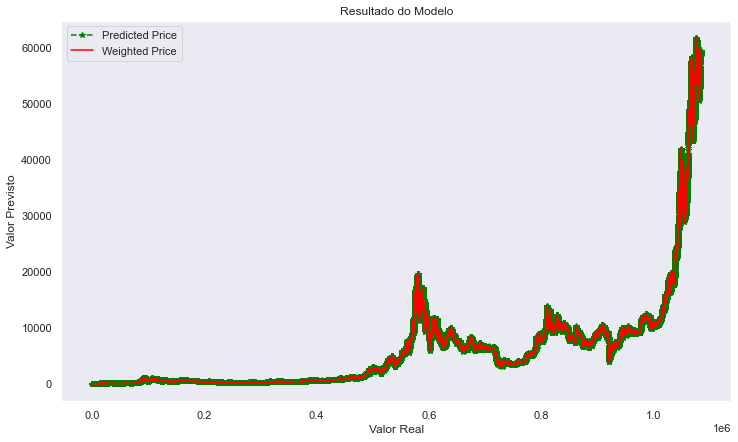

In [90]:
# Plot dos valores Reais x Valores Previstos
plt.figure(figsize = (12, 7))
plt.plot(Y, color = "green", marker = "*", linestyle = "dashed", label = "Predicted Price")
plt.plot(_Y, color = "red", label = "Weighted Price")
plt.title("Resultado do Modelo")
plt.xlabel("Valor Real")
plt.ylabel("Valor Previsto")
plt.legend()

Se surgiram mensagens de warning, é importante ler e verificar, pois algumas delas podem apontar para uma instabilidade do modelo ou sobreajuste. Se este for o caso, devemos usar um modelo sem estas características, ou seja, sem warning ou sobreajuste. 

### Testando um terceiro modelo com mais hiperparâmetros

In [91]:
modelo_lr_v3 = (LinearRegression(featuresCol = "scaled_features",
                                 labelCol = "Weighted_Price", 
                                 predictionCol = "Predicted_Price"                                
                                ))

In [92]:
grid = ParamGridBuilder().addGrid(modelo_lr_v3.maxIter, [50, 60, 70, 80, 90, 100]).build()

In [93]:
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_Price", 
                                metricName = "rmse"
                               )

In [94]:
cv = CrossValidator(estimator = modelo_lr_v3, 
                    estimatorParamMaps = grid, 
                    evaluator = evaluator, 
                    parallelism = 4
)

In [95]:
cvModel = cv.fit(dados_treino_scaled)

In [96]:
modelo_v3 = cvModel.bestModel

In [97]:
previsoes_v3 = modelo_v3.transform(dados_teste_scaled)

In [98]:
pred_data_v3 = previsoes_v3.select("Predicted_Price", "Weighted_Price").show(10)
print("MAE: {0}".format(modelo_v2.summary.meanAbsoluteError))

+------------------+--------------+
|   Predicted_Price|Weighted_Price|
+------------------+--------------+
| 4.502119998497504|          4.39|
| 4.692288571880474|          4.58|
| 5.115092950536393|           5.0|
| 5.432426809952907|          5.32|
| 5.406694437802658|          5.29|
|5.4038345805494234|          5.29|
| 5.302464037330834|          5.19|
| 5.474202029454054|  5.3604618117|
| 5.864358012805859|   5.777027027|
|6.1123889361125645|           6.0|
+------------------+--------------+
only showing top 10 rows

MAE: 3.383969736258383


In [99]:
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_Price", 
                                metricName = "rmse"
                               )

In [100]:
rmse_v3 = evaluator.evaluate(previsoes_v3)
print("Root Mean Squared Error (RMSE) nos dados de teste = %g" % rmse_v3)

Root Mean Squared Error (RMSE) nos dados de teste = 10.4871


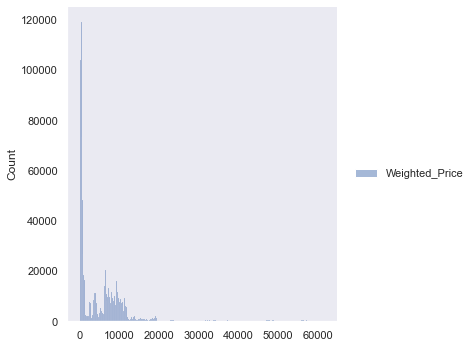

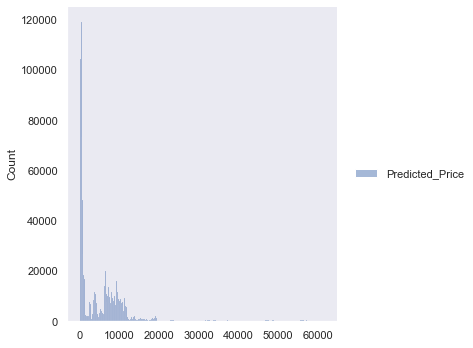

In [101]:
pred_result_v3 = modelo_v2.evaluate(dados_teste_scaled)
Y = pred_result_v3.predictions.select("Weighted_Price").toPandas()
_Y = pred_result_v3.predictions.select("Predicted_Price").toPandas()

sns.set_style("dark")
ax1 = sns.displot(Y, color = "r", label = "Valores Reais")
sns.displot(_Y, color = "g", label = "Valores Previstos");

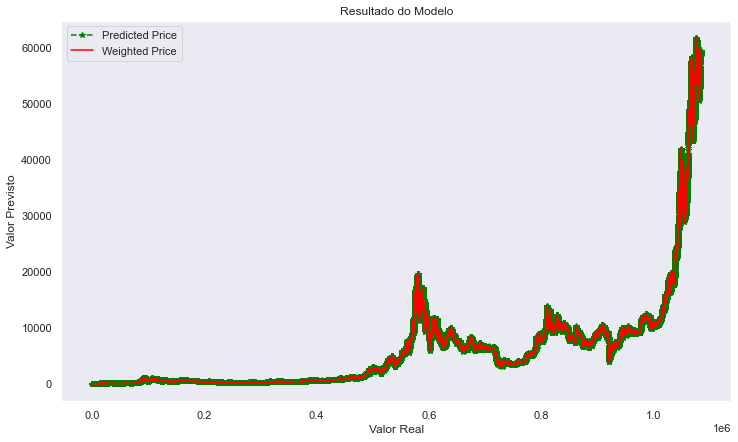

In [102]:
plt.figure(figsize = (12, 7))
plt.plot(Y, color = "green", marker = "*", linestyle = "dashed", label = "Predicted Price")
plt.plot(_Y, color = "red", label = "Weighted Price")
plt.title("Resultado do Modelo")
plt.xlabel("Valor Real")
plt.ylabel("Valor Previsto")
plt.legend();

### Previsões em Tempo Real

In [103]:
novos_dados = [[20546.29, 3422.57, 72403082.02], [21620.85, 3271.14, 71319207.5]]

In [104]:
# Preparar o dataframe do pandas
df_novos_dados = pd.DataFrame(novos_dados, columns = ["Open", "VolBTC", "VolCurrency"])

In [105]:
# Visualizar o DF
df_novos_dados

,Open,VolBTC,VolCurrency
0,20546.29,3422.57,72403082.02
1,21620.85,3271.14,71319207.50


In [106]:
# Converter o dataframe do Pandas para Dataframe do Spark
df_novos_dados_spark = spark_session.createDataFrame(df_novos_dados)

In [107]:
# Schema
df_novos_dados_spark.printSchema()

root
 |-- Open: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)



In [108]:
# Visualiar DF Spark
df_novos_dados_spark.show()

+--------+-------+-------------+
|    Open| VolBTC|  VolCurrency|
+--------+-------+-------------+
|20546.29|3422.57|7.240308202E7|
|21620.85|3271.14| 7.13192075E7|
+--------+-------+-------------+



In [109]:
# Criar o dataframe do vetor de atributos
df_assembled = assembler.transform(df_novos_dados_spark)

In [110]:
# Visualizar os dados
df_assembled.show()

+--------+-------+-------------+--------------------+
|    Open| VolBTC|  VolCurrency|            Features|
+--------+-------+-------------+--------------------+
|20546.29|3422.57|7.240308202E7|[20546.29,3422.57...|
|21620.85|3271.14| 7.13192075E7|[21620.85,3271.14...|
+--------+-------+-------------+--------------------+



In [111]:
# Normalizar os dados
df_assembled_scaled = scalerModel.transform(df_assembled)

In [112]:
# Previsões com os novos dados
previsoes = modelo_v3.transform(df_assembled_scaled)

In [113]:
# Imprimir as previsões
pred_data = previsoes.select("Predicted_Price").show()

+------------------+
|   Predicted_Price|
+------------------+
|20214.246004809767|
|21293.756099392132|
+------------------+



In [114]:
# Encerrar a sessão spark
spark_session.stop()